In [172]:
%env DISPLAY=:0.0
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=16
%env MKL_NUM_THREADS=1
%env NUMEXPR_NUM_THREADS=1

env: DISPLAY=:0.0
env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=16
env: MKL_NUM_THREADS=1
env: NUMEXPR_NUM_THREADS=1


In [173]:
import numpy as np
import matplotlib.pyplot as plt
import os 
import arviz
from cmdstanpy import cmdstan_path, CmdStanModel
import cmdstanpy
%matplotlib inline

import zusammen

## cosmogrb -> Stan

In [174]:
from zusammen.utils.sim2fits import AnalysisBuilder

SynthGRB_0


2020-11-18 16:48:55 Francescas-MacBook-Pro.local astropy[68853] WARNING VerifyWarning: Card is too long, comment will be truncated.
2020-11-18 16:48:55 Francescas-MacBook-Pro.local astropy[68853] WARNING AstropyDeprecationWarning: "clobber" was deprecated in version 2.0 and will be removed in a future version. Use argument "overwrite" instead.

WARNING UserWarning: The TTE file SynthGRB_0/tte_SynthGRB_0_n6.fits contains duplicate time tags and is thus invalid. Contact the FSSC 


WARNING UserWarning: The default choice for MATRIX extension failed:KeyError("Extension ('MATRIX', 1) not found.")available: None 'EBOUNDS' 'SPECRESP MATRIX'




WARNING UserWarning: The TTE file SynthGRB_0/tte_SynthGRB_0_n7.fits contains duplicate time tags and is thus invalid. Contact the FSSC 


WARNING UserWarning: The default choice for MATRIX extension failed:KeyError("Extension ('MATRIX', 1) not found.")available: None 'EBOUNDS' 'SPECRESP MATRIX'


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.536451816558838)




WARNING UserWarning: The TTE file SynthGRB_0/tte_SynthGRB_0_n8.fits contains duplicate time tags and is thus invalid. Contact the FSSC 


WARNING UserWarning: The default choice for MATRIX extension failed:KeyError("Extension ('MATRIX', 1) not found.")available: None 'EBOUNDS' 'SPECRESP MATRIX'


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.910734176635742)




WARNING UserWarning: The TTE file SynthGRB_0/tte_SynthGRB_0_b1.fits contains duplicate time tags and is thus invalid. Contact the FSSC 


WARNING UserWarning: The default choice for MATRIX extension failed:KeyError("Extension ('MATRIX', 1) not found.")available: None 'EBOUNDS' 'SPECRESP MATRIX'




WARNING UserWarning: The default choice for MATRIX extension failed:KeyError("Extension ('MATRIX', 1) not found.")available: None 'EBOUNDS' 'SPECRESP MATRIX' 'SPECRESP MATRIX' 'SPECRESP MATRIX' 'SPECRESP MATRIX' 'SPECRESP MATRIX' 'SPECRESP MATRIX'


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.536451816558838)


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.910734176635742)


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.536451816558838)


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.910734176635742)


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.536451816558838)


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.910734176635742)


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.536451816558

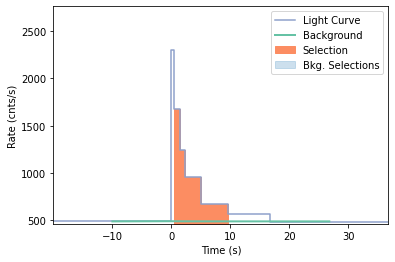

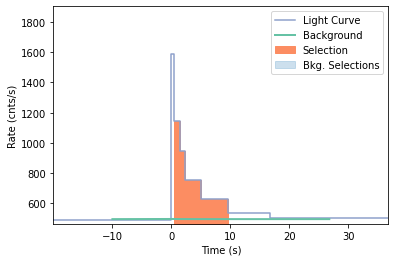

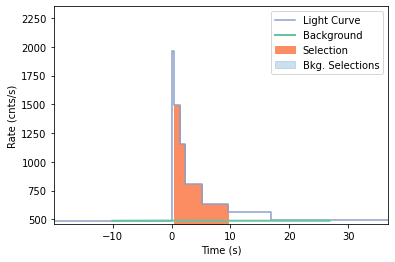

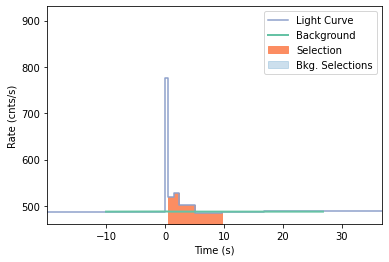

In [175]:
analysis_builder = AnalysisBuilder("data/survey.h5", use_bb=True)
output = zusammen.DataSet.from_dict(analysis_builder.yaml_params)
output.to_hdf5_file("data/survey_proc.h5")

## Fit

In [638]:
ds = zusammen.DataSet.from_hdf5_file('data/survey_proc.h5')

In [639]:
#N_gen_spectra = 100
#model_energy = np.logspace(0,5,N_gen_spectra)
#data['N_gen_spectra'] = N_gen_spectra
#data['model_energy'] = model_energy

warmup = 1000
samps = 1000
total = warmup + samps
chains = 4

In [640]:
model = CmdStanModel(stan_file="stan/simple_cor.stan", 
                     cpp_options={'STAN_THREADS': 'TRUE'})

2020-11-18 21:01:33 Francescas-MacBook-Pro.local cmdstanpy[68853] INFO found newer exe file, not recompiling
2020-11-18 21:01:33 Francescas-MacBook-Pro.local cmdstanpy[68853] INFO compiled model file: /Users/fran/projects/zusammen/examples/stan/simple_cor


In [641]:
os.environ["STAN_NUM_THREADS"] = "8"

data = ds.to_stan_dict()
# TODO: Fix in ogip2stan
data["response"] = data["response"].transpose(0, 1, 3, 2)
cmdstanpy.utils.jsondump("test_data.json", data)

fit = model.sample(
    data=data,
    cores=8,
    iter_warmup=warmup,
    iter_sampling=samps,
    chains=chains,
    max_treedepth=10,
    show_progress="notebook")

av = arviz.from_cmdstanpy(fit)

In [642]:
#fit.summary

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13a25f7f0>,
      dtype=object)

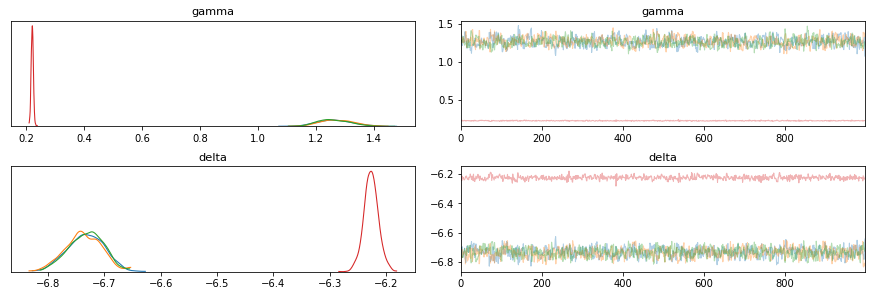

In [643]:
arviz.plot_trace(av, var_names=["gamma", "delta"])

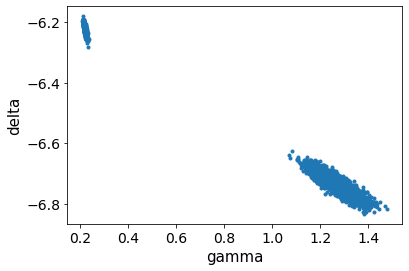

In [644]:
arviz.plot_pair(av, var_names=["gamma", "delta"], divergences=True);

### Compare with truth

In [542]:
from cosmogrb.universe.survey import Survey
from popsynth.distributions.cosmological_distribution import luminosity_distance

In [619]:
survey = Survey.from_file('data/survey.h5')
grb_reload = survey['SynthGRB_0'].grb

gamma_true = grb_reload._source_params["gamma"]
Nrest = grb_reload._source_params["Nrest"] 
z = grb_reload.z
dl = luminosity_distance(grb_reload.z)
delta_true = np.log10(Nrest / (4 * np.pi * dl**2))
alpha_true = grb_reload._source_params["alpha"]
ep_start = grb_reload._source_params["ep_start"]

In [530]:
N_intervals = np.shape(av.posterior.alpha)[-1]

Text(0, 0.5, 'alpha')

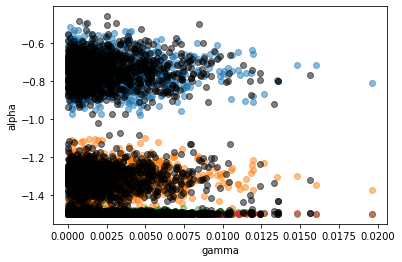

In [533]:
idx = 0
fig, ax = plt.subplots()
for i in range(N_intervals):
    ax.scatter(av.posterior.gamma[1], av.posterior.alpha[1, :, i], alpha=0.5)
for i in range(N_intervals):
    ax.scatter(av.posterior.gamma[idx], av.posterior.alpha[idx, :, i], alpha=0.5, 
               color='k')
ax.set_xlabel("gamma")
ax.set_ylabel("alpha")

Text(0, 0.5, 'alpha')

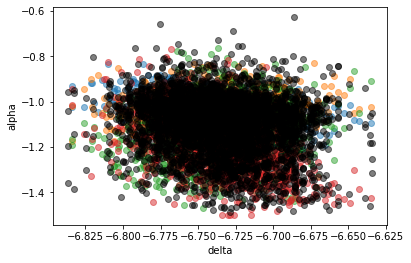

In [508]:
idx = 0
fig, ax = plt.subplots()
for i in range(N_intervals):
    ax.scatter(av.posterior.delta[1], av.posterior.alpha[1, :, i], alpha=0.5)
for i in range(N_intervals):
    ax.scatter(av.posterior.delta[idx], av.posterior.alpha[idx, :, i], alpha=0.5, 
               color='k')
ax.set_xlabel("delta")
ax.set_ylabel("alpha")

Text(0, 0.5, 'log_epeak')

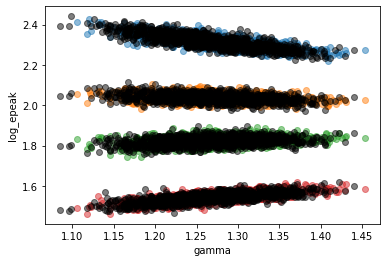

In [509]:
idx = 0
fig, ax = plt.subplots()
for i in range(N_intervals):
    ax.scatter(av.posterior.gamma[1], av.posterior.log_epeak[1, :, i], alpha=0.5)
for i in range(N_intervals):
    ax.scatter(av.posterior.gamma[idx], av.posterior.log_epeak[idx, :, i], alpha=0.5, 
               color='k')
ax.set_xlabel("gamma")
ax.set_ylabel("log_epeak")

Text(0, 0.5, 'log_epeak')

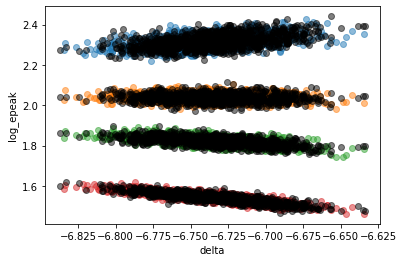

In [510]:
idx = 0
fig, ax = plt.subplots()
for i in range(N_intervals):
    ax.scatter(av.posterior.delta[1], av.posterior.log_epeak[1, :, i], alpha=0.5)
for i in range(N_intervals):
    ax.scatter(av.posterior.delta[idx], av.posterior.log_epeak[idx, :, i], alpha=0.5, 
               color='k')
ax.set_xlabel("delta")
ax.set_ylabel("log_epeak")

Text(0, 0.5, 'log_energy_flux')

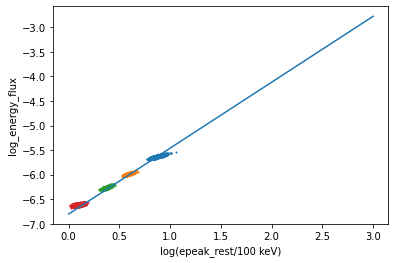

In [511]:
fig, ax = plt.subplots()

for i in range(N_intervals):

    log_epeak_rest = np.log10(10**np.concatenate(av.posterior.log_epeak[:,:,i]) 
                              * (1+z) / 100)
    ax.scatter(log_epeak_rest,
               np.concatenate(av.posterior.log_energy_flux[:,:,i]), s=1)
    
xx = np.linspace(0,3,50)

ax.plot(xx, gamma_true*xx + delta_true)
ax.set_xlabel("log(epeak_rest/100 keV)")
ax.set_ylabel("log_energy_flux")

Text(0.5, 0, 'log_epeak')

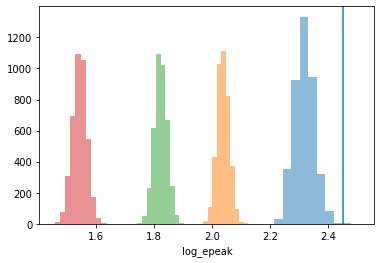

In [513]:
fig, ax = plt.subplots()
for i in range(N_intervals):
    ax.hist(np.concatenate(av.posterior.log_epeak[:,:,i]), alpha=0.5)
ax.axvline(np.log10(ep_start))
ax.set_xlabel("log_epeak")

Text(0, 0.5, 'alpha')

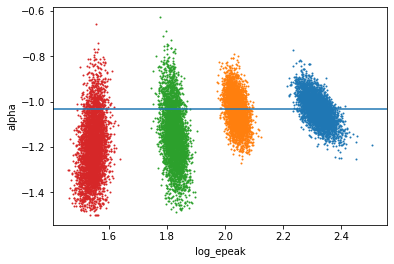

In [515]:
fig, ax = plt.subplots()

for i in range(N_intervals):

    ax.scatter(np.concatenate(av.posterior.log_epeak[:,:,i]),
               np.concatenate(av.posterior.alpha[:,:,i]), s=1)
ax.axhline(alpha_true)
#ax.axvline(np.log10(ep_start))
ax.set_xlabel("log_epeak")
ax.set_ylabel("alpha")

[Text(0, 0.5, 'alpha'), Text(0.5, 0, 'log energy flux')]

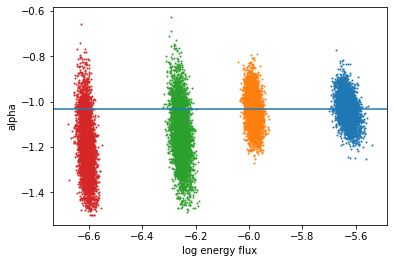

In [517]:
fig, ax = plt.subplots()

for i in range(N_intervals):

    ax.scatter(np.concatenate(av.posterior.log_energy_flux[:,:,i]),
               np.concatenate(av.posterior.alpha[:,:,i]), s=1)
ax.axhline(alpha_true)
ax.set(xlabel="log energy flux", ylabel="alpha")

(array([  1.,   1.,   3.,  16.,  29.,  94., 217., 303., 253.,  83.]),
 array([76207.3 , 76209.03, 76210.76, 76212.49, 76214.22, 76215.95,
        76217.68, 76219.41, 76221.14, 76222.87, 76224.6 ]),
 <a list of 10 Patch objects>)

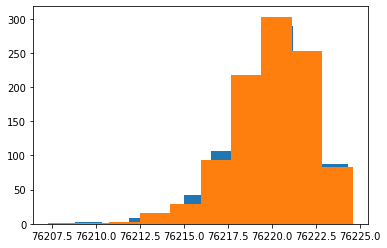

In [518]:
# debug
fig, ax = plt.subplots()
ax.hist(av.sample_stats.lp[1])
ax.hist(av.sample_stats.lp[0])

In [478]:
#av.posterior.to_netcdf("output/simple_cor_fail.nc")

## debug

In [628]:
model = CmdStanModel(stan_file="stan/map_log_like.stan", 
                     cpp_options={'STAN_THREADS': 'TRUE'})

2020-11-18 20:57:27 Francescas-MacBook-Pro.local cmdstanpy[68853] INFO found newer exe file, not recompiling
2020-11-18 20:57:27 Francescas-MacBook-Pro.local cmdstanpy[68853] INFO compiled model file: /Users/fran/projects/zusammen/examples/stan/map_log_like


In [629]:
alpha_fail =  [-1.0, -1.2, -1.3, -1.5] # decreasing
alpha_mid =  [-1.0, -1.1, -1.2, -1.3]
alpha_success = [-1.0, -1.0, -1.0, -1.0] # stable

log_epeak_fail = [2.0, 2.2, 2.4, 2.6] # increasing
log_epeak_mid = [2.0, 2.0, 2.0, 2.0]
log_epeak_success = [2.4, 2.0, 1.8, 1.6] # decreasing

In [630]:
os.environ["STAN_NUM_THREADS"] = "8"
ds = zusammen.DataSet.from_hdf5_file('data/survey_proc.h5')
data = ds.to_stan_dict()
# TODO: Fix in ogip2stan
data["response"] = data["response"].transpose(0, 1, 3, 2)
cmdstanpy.utils.jsondump("test_data.json", data)

#extras
data["N_grid"] = 50
data["gamma_grid"] = np.linspace(-2, 2)
data["delta_grid"] = np.linspace(-8, 0)
data["alpha"] = alpha_fail
data["log_epeak"] = log_epeak_fail
fit = model.sample(
    data=data,
    fixed_param=True, 
    cores=8,
    iter_sampling=1,
    chains=1,
    show_progress="notebook")

av = arviz.from_cmdstanpy(fit)

Text(0.5, 1.0, 'fail')

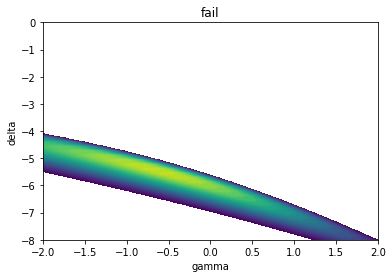

In [631]:
fig, ax = plt.subplots()
ll = av.posterior.log_like[0][0]
ax.contourf(data["gamma_grid"], data["delta_grid"], 
            ll, levels=np.linspace(72000, 76225))
ax.set_xlabel("gamma")
ax.set_ylabel("delta")
ax.set_title("fail")

In [632]:
data["alpha"] = alpha_success
data["log_epeak"] = log_epeak_success
fit = model.sample(
    data=data,
    fixed_param=True, 
    cores=8,
    iter_sampling=1,
    chains=1,
    show_progress="notebook")

av = arviz.from_cmdstanpy(fit)

Text(0.5, 1.0, 'success')

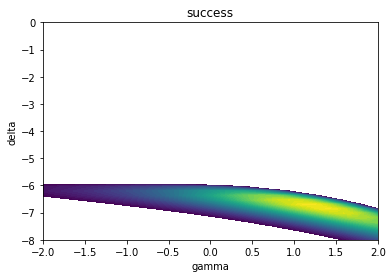

In [633]:
fig, ax = plt.subplots()
ll = av.posterior.log_like[0][0]
ax.contourf(data["gamma_grid"], data["delta_grid"], 
            ll, levels=np.linspace(72000, 76225))
ax.set_xlabel("gamma")
ax.set_ylabel("delta")
ax.set_title("success")

In [634]:
data["alpha"] = alpha_mid
data["log_epeak"] = log_epeak_mid
fit = model.sample(
    data=data,
    fixed_param=True, 
    cores=8,
    iter_sampling=1,
    chains=1,
    show_progress="notebook")

av = arviz.from_cmdstanpy(fit)

Text(0.5, 1.0, 'mid')

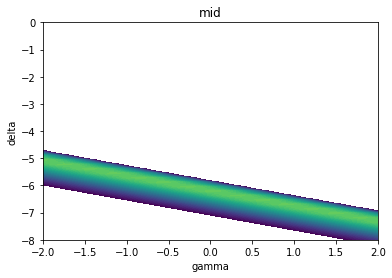

In [635]:
fig, ax = plt.subplots()
ll = av.posterior.log_like[0][0]
ax.contourf(data["gamma_grid"], data["delta_grid"], 
            ll, levels=np.linspace(72000, 76225))
ax.set_xlabel("gamma")
ax.set_ylabel("delta")
ax.set_title("mid")